In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) #ignore the warning to keep ipython clean

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [37]:
train = pd.read_csv("Data/train.csv", parse_dates=['timestamp'])
y = train["price_doc"]
ylog = np.log(y)
train = train.drop(["price_doc"], axis=1)
num_train = train.shape[0]

test = pd.read_csv("Data/test.csv", parse_dates=['timestamp'])
data = pd.concat([train, test], axis=0)
print train.shape, test.shape, data.shape

(30471, 291) (7662, 291) (38133, 291)


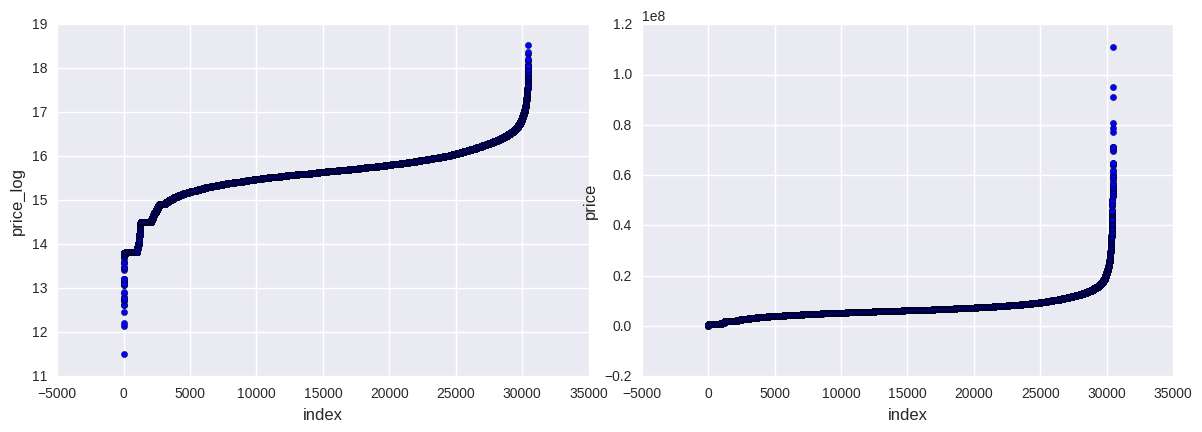

In [38]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)

axs[0].scatter(range(train.shape[0]), np.sort(ylog))
axs[0].set_xlabel('index', fontsize=12)
axs[0].set_ylabel('price_log', fontsize=12)

axs[1].scatter(range(train.shape[0]), np.sort(y))
axs[1].set_xlabel('index', fontsize=12)
axs[1].set_ylabel('price', fontsize=12)


In [39]:
# truncate the extreme values in price_doc #
ulimit = np.percentile(ylog, 99)
llimit = np.percentile(ylog, 1)
ylog[ylog>ulimit] = ulimit
ylog[ylog<llimit] = llimit

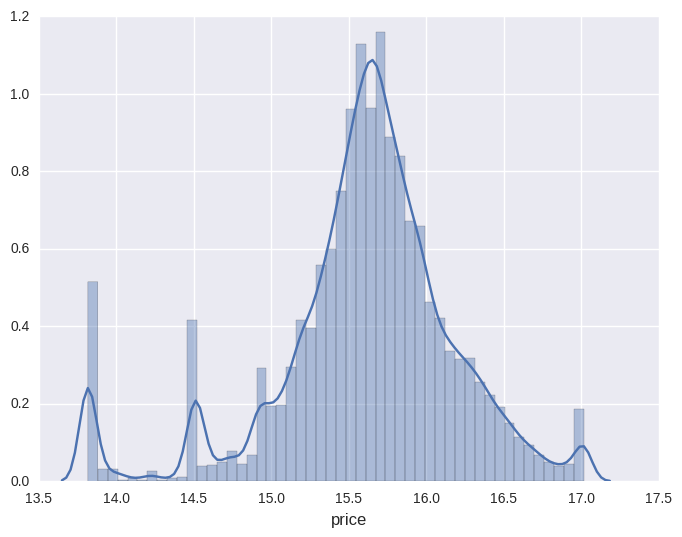

In [40]:
plt.figure(figsize=(8,6))
sns.distplot(ylog, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

In [41]:
data["year"] = data["timestamp"].dt.year
data["month"] = data["timestamp"].dt.month
data["week"] = data["timestamp"].dt.weekofyear # week of year
data["day"] = data["timestamp"].dt.weekday

In [42]:
data["time_month"] = (data['year'] - 2011) * 12 + data["month"]
data["time_week"] = (data['year'] - 2011) * 53 + data["week"]

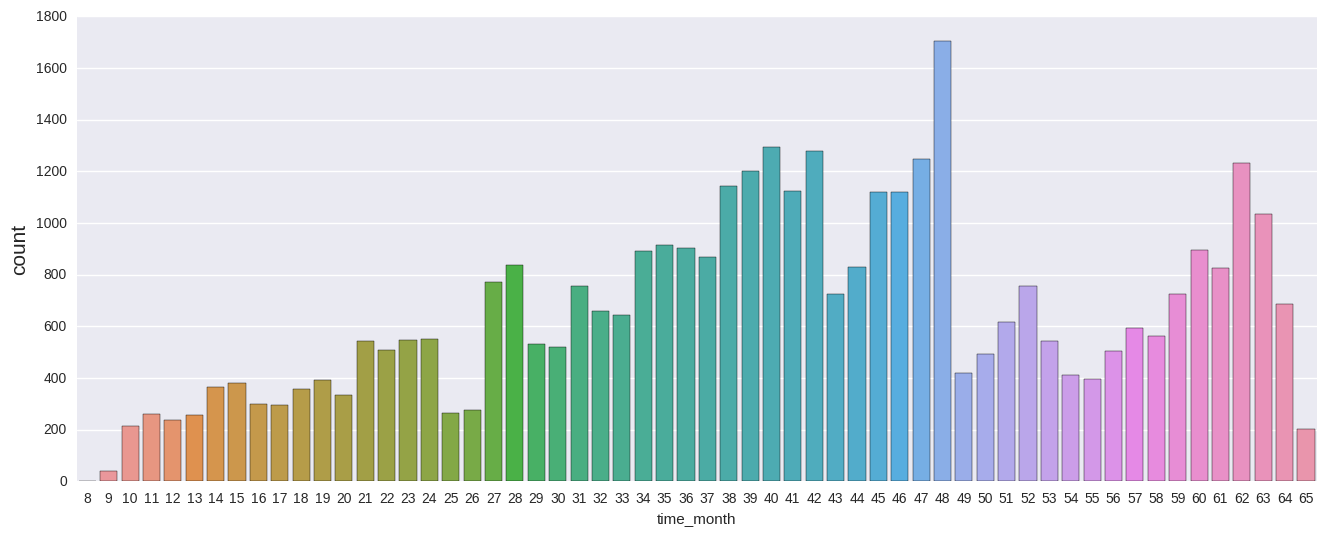

In [82]:
fig, axs = plt.subplots(ncols=1, figsize=(16, 6))
sns.countplot(x = 'time_month', data = data, ax=axs)
axs.set_ylabel('count', fontsize=15)


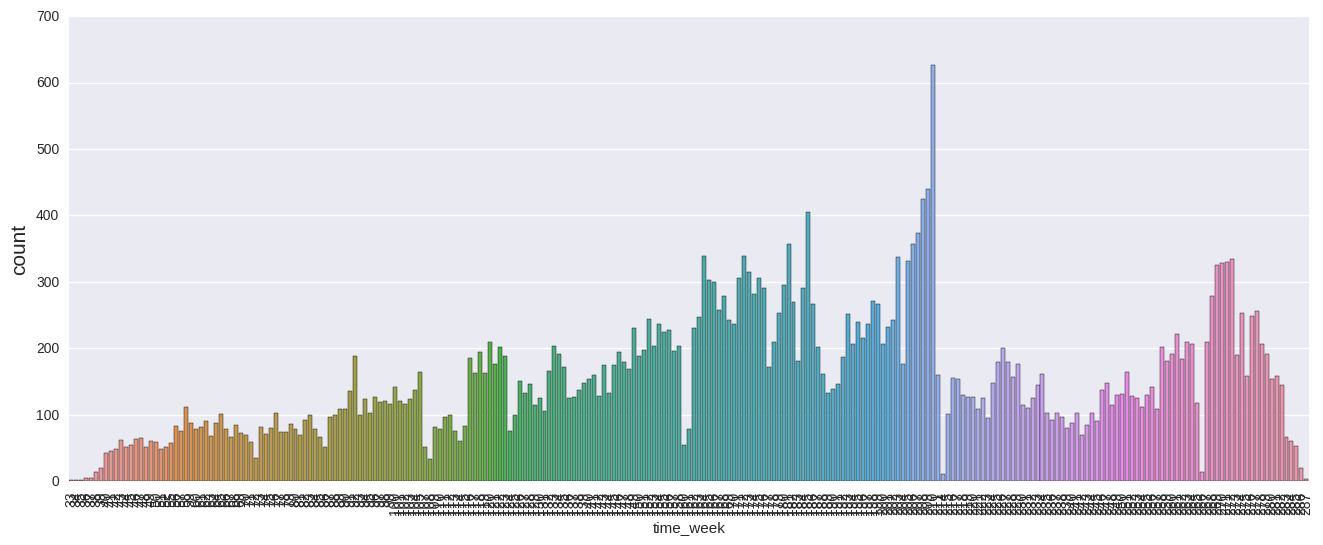

In [84]:
fig, axs = plt.subplots(ncols=1, figsize=(16, 6))
sns.countplot(x = 'time_week', data = data, ax=axs)
axs.set_ylabel('count', fontsize=15)
plt.xticks(rotation=90)
plt.show()

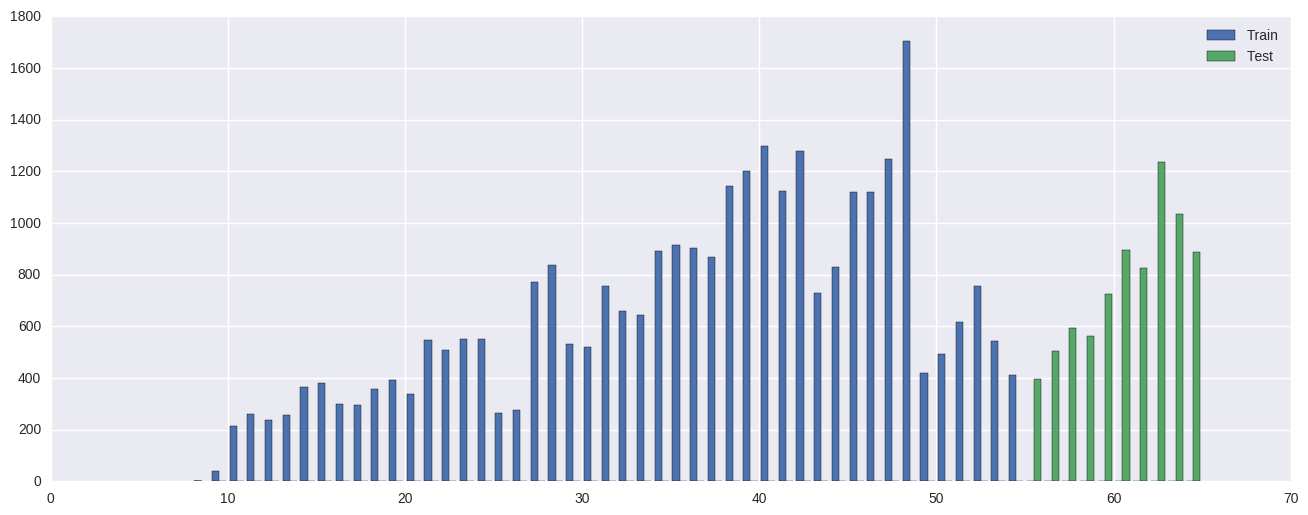

In [80]:
fig, axs = plt.subplots(ncols=1, figsize=(16, 6))
binsize = 57
B=['Train','Test']
t1 = data[:num_train].time_month.values
t2 = data[num_train:].time_month.values
plt.hist([t1, t2] , binsize, histtype='bar', align='mid', range=(8,65), label=B, alpha=1.)
axs.legend()

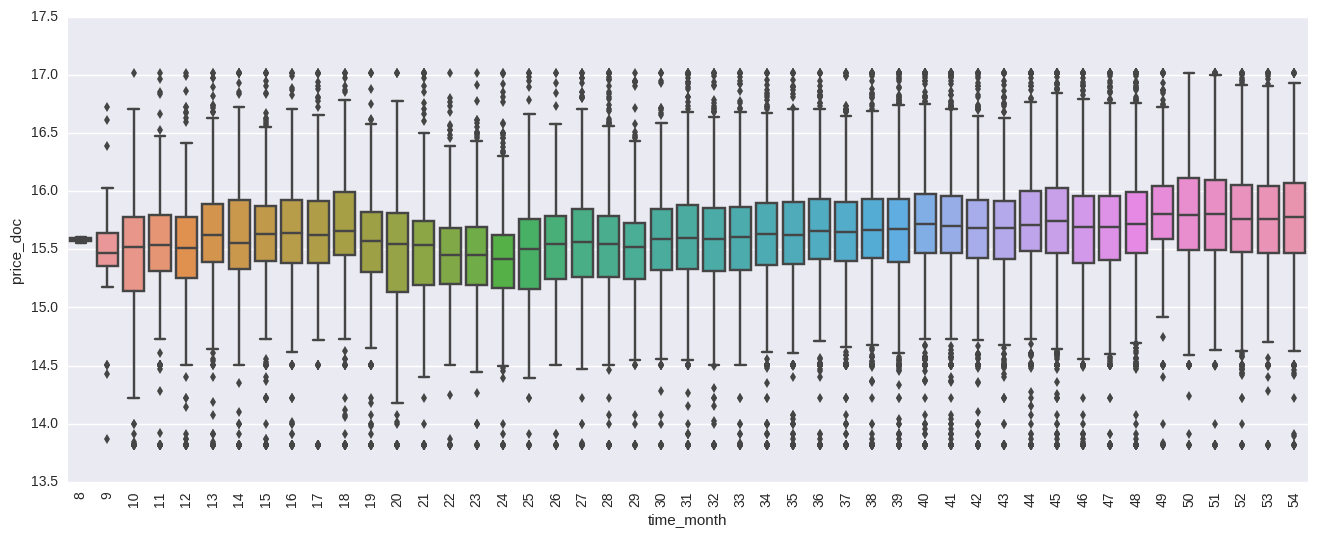

In [91]:
plt.figure(figsize=(16,6))
sns.boxplot(x = "time_month", y = ylog, data = data[:num_train])
plt.xticks(rotation = 90)
plt.show()

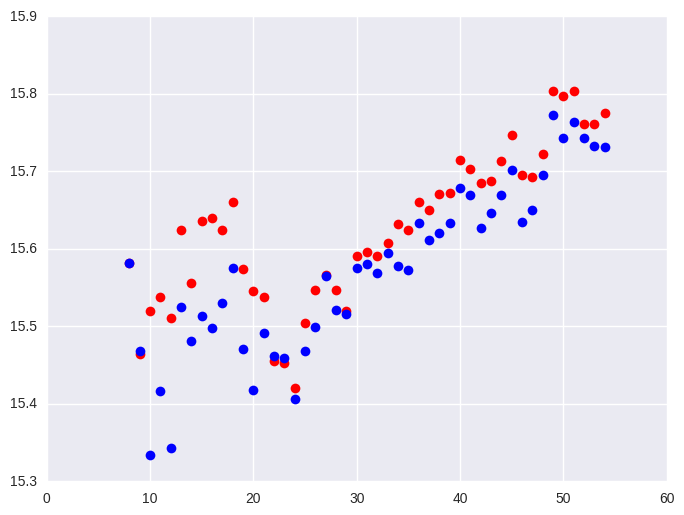

In [125]:
tt = data[:num_train]
tt = tt[["time_month", "time_week"]]
tt['price'] = ylog
tt['time_month'] = tt["time_month"].apply(str)
price_median = tt.groupby('time_month')['price'].aggregate(np.median).reset_index()
price_mean = tt.groupby('time_month')['price'].aggregate(np.mean).reset_index()

plt.figure(figsize=(8,6))
plt.plot(price_median["time_month"], price_median["price"], 'ro',
         price_mean["time_month"], price_mean["price"], 'bo')




TypeError: 'tuple' object is not callable

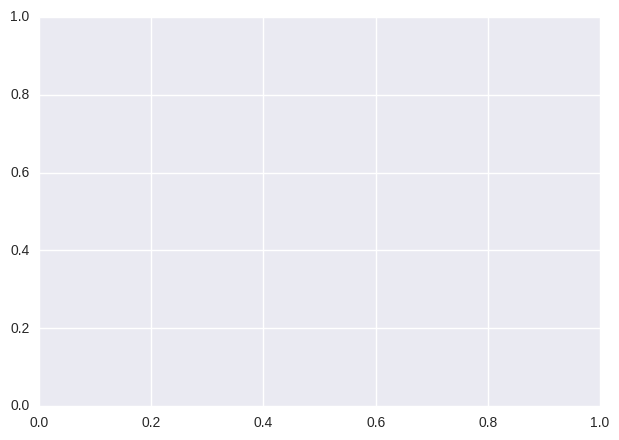

In [ ]:
sns.factorplot('time_month', 'price', estimator = np.median, data = tt, 
             size = 4.5, aspect = 1.4)